# Testing various evidence functions

In [1]:
# imports

import os
import os.path as osp
import sys
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from mmengine import Config
from mmengine.dataset import default_collate
from mmpretrain.apis import get_model
from mmpretrain.registry import DATASETS
from mmpretrain.structures import DataSample

import torch
import torchvision.transforms.functional as TF

In [2]:
# include parent path
sys.path.append(os.path.abspath('..'))

In [25]:
# evidence deep learning cfg
relu_cfg = Config.fromfile('../configs/edl_mnist/edl_relu_lenet5_mnist.py')
relu_ckpt = '../work_dirs/edl_relu_lenet5_mnist/epoch_15.pth'
assert osp.exists(relu_ckpt)

exp_cfg = Config.fromfile('../configs/edl_mnist/edl_exp_lenet5_mnist.py')
exp_ckpt = '../work_dirs/edl_exp_lenet5_mnist/epoch_15.pth'
assert osp.exists(exp_ckpt)

etanh_cfg = Config.fromfile('../configs/edl_mnist/edl_etanh_lenet5_mnist.py')
etanh_ckpt = '../work_dirs/edl_etanh_lenet5_mnist/epoch_10.pth'
assert osp.exists(etanh_ckpt)   

First, we need to create a dataset with a single image and rotate it from 0 to 180 degrees. 

In [26]:
# avoid overwriting the original config
print(relu_cfg.test_dataloader.dataset)
dataset_cfg: dict = deepcopy(relu_cfg.test_dataloader.dataset)

# append '../' to the data_prefix
dataset_cfg['data_prefix'] = osp.join('../', dataset_cfg['data_prefix'])

dataset = DATASETS.build(dataset_cfg)
print(type(dataset))

{'type': 'MNIST', 'data_prefix': 'data/mnist', 'pipeline': [{'type': 'Resize', 'scale': 32}, {'type': 'PackInputs'}], 'test_mode': True}
<class 'mmpretrain.datasets.mnist.MNIST'>


In [27]:
# the "1" examples is the 2nd sample in the test dataset
sample = dataset[2]
print(sample['data_samples'].gt_label)

tensor([1])


In [28]:
# Create DataSample of Rotated MNIST

def create_rotated_mnist_sample(sample: dict):
    img: torch.Tensor = sample['inputs']
    data_sample: DataSample = sample['data_samples']

    m = 180
    n = m // 10 + 1
    degs = torch.linspace(0, m, n)
    samples = []
    for deg in degs:
        img_rot = TF.rotate(img.clone(), float(deg), fill=0)
        ds = data_sample.clone()
        ds.set_field(deg, 'rotation', torch.Tensor)
        samples.append(
            dict(
                inputs=img_rot,
                data_samples=ds,
            )
        )

    return samples

samples = create_rotated_mnist_sample(sample)

We need to create a batch of all samples and perform inference on the loaded model.

In [29]:
def make_batch(data: list):
    return default_collate(data)

data = make_batch(samples)

In [30]:
# Load the model
relu_model = get_model(relu_cfg, pretrained=relu_ckpt)
exp_model = get_model(exp_cfg, pretrained=exp_ckpt)
etanh_model = get_model(etanh_cfg, pretrained=etanh_ckpt)

Loads checkpoint by local backend from path: ../work_dirs/edl_relu_lenet5_mnist/epoch_15.pth
Loads checkpoint by local backend from path: ../work_dirs/edl_exp_lenet5_mnist/epoch_15.pth
Loads checkpoint by local backend from path: ../work_dirs/edl_etanh_lenet5_mnist/epoch_10.pth


In [31]:
# inference
relu_model.eval()
relu_out = relu_model.test_step(deepcopy(data))

exp_model.eval()
exp_out = exp_model.test_step(deepcopy(data))

etanh_model.eval()
etanh_out = etanh_model.test_step(deepcopy(data))

print(len(relu_out))
print(relu_out[0])

19
<DataSample(

META INFORMATION
    num_classes: 10
    sample_idx: 2
    img_shape: (32, 32)
    scale_factor: (1.1428571428571428, 1.1428571428571428)

DATA FIELDS
    rotation: 0.0
    gt_label: tensor([1])
    pred_score: tensor([0.0065, 0.9412, 0.0065, 0.0065, 0.0065, 0.0065, 0.0065, 0.0065, 0.0065,
        0.0065])
    pred_label: tensor([0.0866, 0.2205, 0.0866, 0.0866, 0.0866, 0.0866, 0.0866, 0.0866, 0.0866,
        0.0866])
    uncertainty: tensor([0.0653])

) at 0x7f4ec0aa6100>


In [32]:
def plot(results, name, threshold=0.5):
    uncertainty = torch.stack([o.uncertainty for o in results])
    probs = torch.stack([o.pred_score for o in results])
    preds = probs.argmax(dim=-1)
    imgs = torch.cat([s['inputs'] for s in samples], dim=-1).squeeze(0)
    degs = torch.stack([o.rotation for o in results])

    # obtain labels where the probability is greater than `threshold`
    scores = np.zeros((10))
    for o in results:
        scores += o.pred_score.cpu().numpy() >=  threshold
    print(scores)

    labels = np.arange(10)[scores.astype(bool)].tolist()
    lprobs = np.array(probs.cpu())[:, labels]

    fig = plt.figure(figsize=[6.2, 5])
    fig, (ax1, ax2, ax3) = plt.subplots(
        3,
        1,
        gridspec_kw={"height_ratios": [4, 1, 12]},
    )

    ax1.imshow(255 - imgs, cmap="gray")
    ax1.axis(False)

    empty_lst = []
    empty_lst.append(preds.tolist())
    ax2.table(cellText=empty_lst, bbox=[0, 1.2, 1, 1])
    ax2.axis("off")

    c = ["black", "blue", "brown", "purple", "cyan", "red"]
    marker = ["s", "^", "o"] * 2

    for i in range(len(labels)):
        ax3.plot(degs, lprobs[:, i], marker=marker[i], c=c[i])

    labels += ["uncertainty"]
    ax3.plot(degs, uncertainty, color="red", marker="<")

    ax3.set_ylabel("Probability")
    ax3.set_xlabel("Rotation Degrees")
    ax3.legend(labels)
    ax3.set_xlim([0, 180])
    ax3.set_ylim([0, 1])

    ax1.set_title(f'{name}')
    plt.show()

[ 0. 11.  0.  0.  0.  0.  0.  0.  0.  0.]


<Figure size 620x500 with 0 Axes>

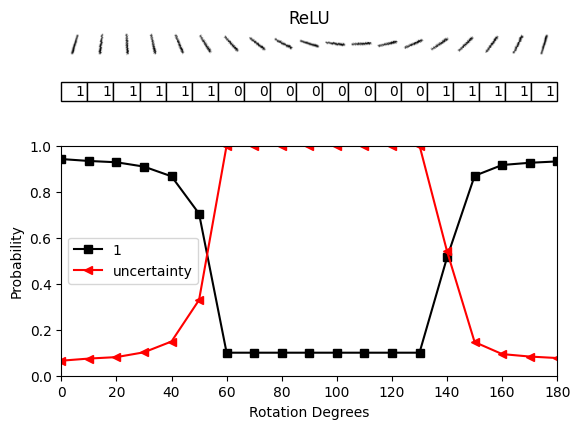

In [33]:
# relu plot
plot(relu_out, 'ReLU')

[ 0. 10.  0.  0.  0.  0.  0.  2.  0.  0.]


<Figure size 620x500 with 0 Axes>

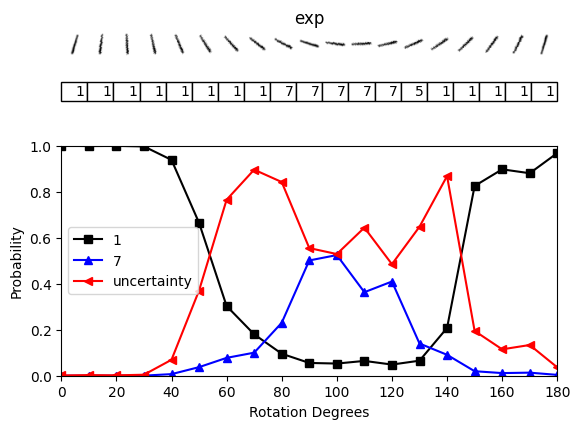

In [34]:
# exp plot
plot(exp_out, 'exp')

[ 0. 11.  0.  0.  0.  0.  0.  5.  0.  0.]


<Figure size 620x500 with 0 Axes>

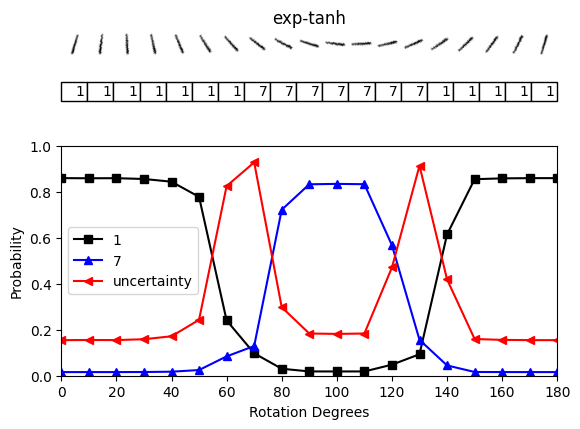

In [35]:
# exp-tanh plot
plot(etanh_out, 'exp-tanh')